# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 22

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

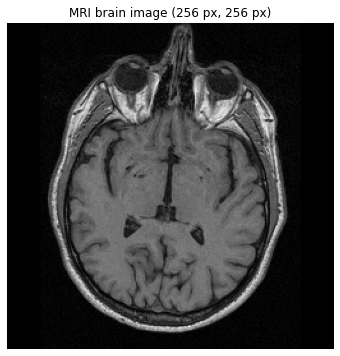

In [2]:
import skimage.io
import skimage.measure
import skimage.filters
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

#### Process explanation
In order to find an approximate greyscale value representing well the brain surface, a 20x20 pixels sample is taken and its mean is computed in order to get an idea of around which value we are interested.
Two thresholds are defined, below and above which the pixels are considered in or out of the brain zone.
A starting point inside the brain zone is then manually defined.
The main work consists in exploring the zone from the starting point : while the complete region of interest is not ran through, we keep exploring the surrounding pixels.

The 8 surrounding pixels are being traveled for each pixel of interest.
- When a pixel has never been seen : it is labeled as "part of the brain" if it lies inside the threshold range, and labeled as "no part of the brain" if not
- If a pixel has already been explored, it is re processed once to make sure no point was forgotten

When the algorithm does not find any more point of interest, it stops. Lastly a mask removing the values of no interest is applied so that the brain only is shown.

Advantages : 
- The region growing algorithm is useful to isolate elements of interest that are surrounded by other elements we do not focus the study on.
- Several criteria can be chosen to define the growing behavior
- Labeling of points allow a rapid computation for "reasonable" sized images

Limitations :
- It can be sensitive to noise, the image in that case should be pre processed before using the algorithm
- The starting point might make the results differ a lot
- Computation could be heavy for large images, as every point in the region will be ran through
- Multiple criteria might not be enough to separate the region of interest to the rest, depending on the geometry

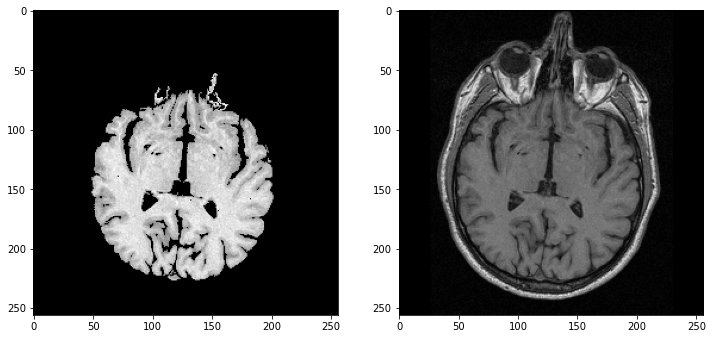

The number of pixels in the brain region is 16834


In [3]:
# Add your implementation and discussion
length=brain_im.shape[0] # Length of image
sample=brain_im[130:150,140:160] # Sample of image to mean onto
brain_copy=brain_im.copy()

thresh=np.mean(sample)*0.6
thresh2=np.mean(sample)*1.2

start=[200,70]
region=[start]
Exploring_map=np.zeros((length,length))
Exploring_map[start[0],start[1]]=2
process=True

while process :
    for pixel in region:
        X,Y = np.mgrid[pixel[0]-1:pixel[0]+2,pixel[1]-1:pixel[1]+2]#Find surrounding pixels
        Xsurr,Ysurr=np.vstack((X.ravel(), Y.ravel())) 
        Surr=np.vstack((Xsurr,Ysurr)).T #Making array with surrounding pixels coordinates
        for exp in Surr :
            if (Exploring_map[exp[0],exp[1]] == 0): # If never explored
                if brain_copy[exp[0],exp[1]]>thresh and brain_copy[exp[0],exp[1]]<thresh2 : #If in range for brain
                    Exploring_map[exp[0],exp[1]] = 2
                else:
                    Exploring_map[exp[0],exp[1]] = 1 # If never explored and not in threshold
            elif Exploring_map[exp[0],exp[1]] ==2:# If already inquired, try once more for pixels around
                Exploring_map[exp[0],exp[1]]=3
            elif Exploring_map[exp[0],exp[1]] ==3:# If already inquired, exclude from next pixels to explore
                Exploring_map[exp[0],exp[1]]=4    
                
    region=np.vstack((np.where((Exploring_map==2)|(Exploring_map==3)))).transpose()
    if region.shape[0]==0:
        process = False
    
mask=(Exploring_map<2)
brain_copy[mask]=0 #See the whole brain region

# Display Images of the brain
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_copy,cmap='gray')
ax[1].imshow(brain_im, cmap='gray')
plt.show()

print('The number of pixels in the brain region is',np.count_nonzero(brain_copy))


### 1.3 Contour detection (5pts)

### 1.4 Additional method (5pts)

In [4]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [5]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


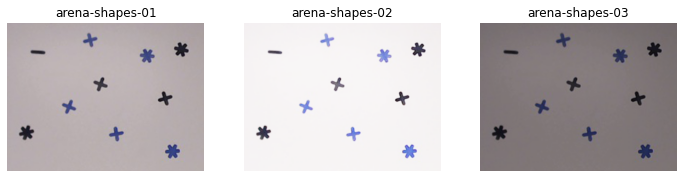

In [6]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()


### 2.2 Number of shapes of each color (5 pts)

#### Process explanation
The library open Cv is here used to compute the colors and the number of shapes of each color.
Two main functions are here used :
- A normalization function in order to get coherent results for different intensities
- A function to get a number of shades of colors of an image, with its associated number of pixels

A loop is then created to find the number of dominant colors in the image : starting from a total of 10 colors, the number decreases until the colors found are sufficiently different one from another.

In the aim of finding the number of shapes, the contours are found using the cv library. Once the number of shapes is found, each shape is associated with a previously found color by finding the closest from its own color.

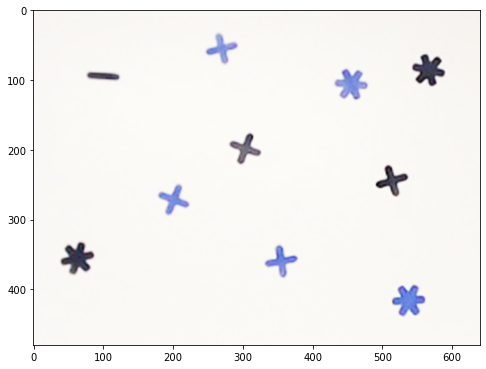

The number of dominant colors in this image is :  3


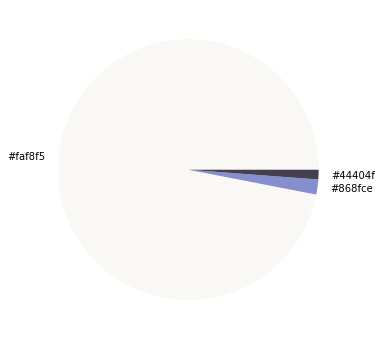

In [7]:
#Source :
#https://github.com/kb22/Color-Identification-using-Machine-Learning/blob/master/Color%20Identification%20using%20Machine%20Learning.ipynb

import cv2
from collections import Counter
from skimage import measure
from skimage.color import rgb2lab, deltaE_cie76,rgb2gray
from sklearn.cluster import KMeans
import itertools
from PIL import Image
import scipy as sc

def get_image(num):
    image = images[num]
    return image

def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_colors(image, number_of_colors, show_chart):
    modified_image = image
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
   
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors,counts


image = get_image(1) #Choose which image to take

arr=np.array(image)
image = np.array(Image.fromarray(normalize(arr).astype('uint8'),'RGB'))  #Normalize it

fig, ax = plt.subplots(1, 1, figsize=(8, 8)) #Plot it
ax.imshow(image)
plt.show()

not_stable = True
num_colors=10 #Initial number of colors to be found in the image

while not_stable:
    rgb,counts=get_colors(image, num_colors, False)
    it=0

    for a, b in itertools.combinations(rgb, 2): #Compare every color with all the others
        it+=1
        if np.linalg.norm(a-b)<100: #If shades of color are too close
            num_colors-=1 
            break
        else: 
            if(it==sc.special.binom(num_colors,2)): #Check if last iteration
                rgb,counts=get_colors(image, num_colors, True)
                not_stable = False        
print('The number of dominant colors in this image is : ', num_colors)



In [8]:
# Find the contours to find the number of elements
gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 190, 255, 0)
contours, hierarchy= cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
number_of_objects_in_image= len(contours)

colpix=np.array(list(counts.copy().items()))
idx=np.argmax(colpix[:,1])
colpix = np.delete(colpix,idx,0)#Remove background from colors for the objects

#Find to which color the elements belong
color_table=np.zeros(number_of_objects_in_image)
for num in range(number_of_objects_in_image):
    center=(np.floor(np.mean(contours[num],axis=0)))
    weight_color=1000
    for num2 in range(num_colors):       
        new_weight=np.linalg.norm(image[int(center[0,1]),int(center[0,0])]-rgb[num2])
        if(new_weight<weight_color):
            weight_color=new_weight
            color_table[num]=num2

            
color_table = np.delete(color_table,idx)
#print('Color table:',color_table)
print ("The number of objects in this image: ", str(number_of_objects_in_image-1))
for num in colpix[:,0]:
    print('The number of shape for color',num,'is',list(color_table).count(num))
    
#To draw the contours :
'''
cv2.drawContours(image,contours,-1,(0,255,255),2)
cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
cv2.imshow('Display',image)
cv2.waitKey()
'''

The number of objects in this image:  10
The number of shape for color 1 is 5
The number of shape for color 2 is 5


"\ncv2.drawContours(image,contours,-1,(0,255,255),2)\ncv2.namedWindow('Display',cv2.WINDOW_NORMAL)\ncv2.imshow('Display',image)\ncv2.waitKey()\n"

### 2.3 Total area (in pixels) of each color (5 pts)

The number of pixels in total for both colors are previously derived using the open cv library.

In [9]:

for num in colpix[:,0]: 
    print('The number of pixels for the color',num,'is',colpix[num-1,1])

The number of pixels for the color 1 is 5715
The number of pixels for the color 2 is 3665
